In [18]:
import pickle
with open('../scenario-properties-frag-spread.pkl', 'rb') as f:
    data = pickle.load(f)

In [22]:
data.collision_pairs[2].eqs

IndexError: list index out of range

In [19]:
# loop through all of the colliions pairs and print when species1.sym_name and species2.sym_name are the same
for i in range(len(data.collision_pairs)):
    if data.collision_pairs[i].species1.sym_name == data.collision_pairs[i].species2.sym_name:
        print(data.collision_pairs[i].species1.sym_name, data.collision_pairs[i].species2.sym_name)
        print(data.collision_pairs[i].eqs)
        print('\n')

In [111]:
import sympy as sp

debris_species = data.species['debris']
for collision_pair in data.results:
    # Ensure gamma is a sympy matrix
    gamma_sympy = collision_pair.gamma
    
    # Start inserting new columns after the existing ones
    insert_index = gamma_sympy.shape[1]
    
    for i in range(2):
        # Extract the column as a numpy array
        column = collision_pair.gammas[:, i]
        
        # Convert the numpy column to a sympy matrix
        column_sympy = sp.Matrix(column)
        
        # Use col_insert to add the new column. Insert at the current insert_index
        gamma_sympy = gamma_sympy.col_insert(insert_index, column_sympy)
        
        # Increment the insert_index for the next column
        insert_index += 1
    
    # Update collision_pair.gamma with the new value
    collision_pair.gamma = gamma_sympy

# Print the updated gamma_sympy for verification
print("Updated gamma_sympy:", gamma_sympy)

Updated gamma_sympy: Matrix([[-1, -1, 0, 0], [-1, -1, 0, 0], [-1, -1, 0, 0], [-1, -1, 0, 0], [-1, -1, 0, 0]])


In [112]:
data.results[25].gamma

Matrix([
[-1, -1,  0.6, 0],
[-1, -1, 1.05, 0],
[-1, -1,  0.9, 0],
[-1, -1,  0.8, 0],
[-1, -1,  1.0, 0]])

In [33]:
from sympy import symbols, Matrix, pi, S, Expr, zeros

class SpeciesPairClass:
    def __init__(self, species1, species2, gammas, source_sinks, scen_properties, fragsMadeDV=None):
        """
        This makes the species pair class associated with a collision between species1
        and species2. It will then create equations for the collision probability modifiers
        in gamma and the species in source_sinks.

        If the symbolic argument "n_f" is passed, it will be replaced with the n_f value
        for a collision involved species1 and species2 at each dv in scen_properties.v_imp2

        Other species will gain from a collision - e.g. debris. 

        Args:
            species1 (Species): The first species in the collision
            species2 (Species): The second species in the collision
            gammas (np.ndarray): The collision probability modifiers for each species in source_sinks.
            A scalar or a N x M matrix, where N is the number of altitude bins and M is the number of species
            with population addition/subtractions where this collision types occur. 
            source_sinks (list): A list of species that are either sources or sinks in the collision
            scen_properties (ScenarioProperties): The scenario properties object
        """
        if gammas.shape[1] != len(source_sinks):
            raise ValueError("Gammas and source_sinks must be the same length")
    
        # As species is a dictionary, it needs to be flatted first        
        all_species = [species for category in scen_properties.species.values() for species in category]

        self.name = f"species_pair({species1.sym_name}, {species2.sym_name})"
        self.species1 = species1
        self.species2 = species2

        meter_to_km = 1 / 1000

        # Square of impact parameter
        self.sigma = (species1.radius * meter_to_km + \
                      species2.radius * meter_to_km) ** 2

        # Scaling based on v_imp, shell volume, and object radii
        self.phi = pi * scen_properties.v_imp2 / (scen_properties.V * meter_to_km**3) * self.sigma * S(86400) * S(365.25)

        # Check if collision is catastrophic
        self.catastrophic = self.is_catastrophic(species1.mass, species2.mass, scen_properties.v_imp2)

        # Fragment generation equations
        M1 = species1.mass
        M2 = species2.mass
        LC = scen_properties.LC
        
        nf = zeros(len(scen_properties.v_imp2), 1)

        for i, dv in enumerate(scen_properties.v_imp2):
            if self.catastrophic[i]:
                # number of fragments generated during a catastrophic collision (NASA standard break-up model). M is the sum of the mass of the objects colliding in kg
                n_f_catastrophic = 0.1 * LC**(-S(1.71)) * (M1 + M2)**(S(0.75))
                nf[i] = n_f_catastrophic
            else:
                # number of fragments generated during a non-catastrophic collision (improved NASA standard break-up model: takes into account the kinetic energy). M is the mass of the less massive object colliding in kg
                n_f_damaging = 0.1 * LC**(-S(1.71)) * (min(M1, M2) * dv**2)**(S(0.75))
                nf[i] = n_f_damaging

        self.nf = nf.transpose() 
            
        self.gammas = gammas
        self.source_sinks = source_sinks
        self.eqs = Matrix(scen_properties.n_shells, len(all_species), lambda i, j: 0)

        if isinstance(self.phi, (int, float, Expr)):
            phi_matrix = Matrix([self.phi] * len(gamma))
        else:
            phi_matrix = Matrix(self.phi)

        if scen_properties.fragment_spreading:
            product_sym = species1.sym.multiply_elementwise(species2.sym).T



        # Go through each gamma (which modifies collision for things like collision avoidance, or fragmentation into 
        # derelicsts, etc.) We increment the eqs matrix with the gamma * phi * species1 * species2.
        for i in range(gammas.shape[1]):
            gamma = gammas[:, i]
            eq_index = None
            for idx, spec in enumerate(all_species):
                if spec.sym_name == source_sinks[i].sym_name:
                    eq_index = idx
                    break

            if eq_index is None:
                raise ValueError(f"Equation index not found for {source_sinks[i].sym_name}")
            
            n_f = symbols(f'n_f:{scen_properties.n_shells}')

            if scen_properties.fragment_spreading:
                if i < 2:  # As first two columns are the reduction of the species in the collision (i.e -1)
                    eq = gamma.multiply_elementwise(phi_matrix).multiply_elementwise(species1.sym).multiply_elementwise(species2.sym)
                else:  # Debris generated from collision
                    try:                         
                        fragsMadeDVcurrentDeb = fragsMadeDV[:, i-2] # First two rows are the reduction of the species in the collision (i.e -1)

                        # Create the 2D fragment matrix with circular shifts
                        fragsMade2D_list = [np.roll(fragsMadeDVcurrentDeb, shift) for shift in range(scen_properties.n_shells + 1)]
                        fragsMade2D = np.column_stack(fragsMade2D_list)

                        # Adjust the slicing to match MATLAB's slicing
                        fragsMade2D = fragsMade2D[scen_properties.n_shells:, :scen_properties.n_shells]  # from N_shell:end for rows, 1:N_shell for columns
                        fragsMade2D_sym = Matrix(fragsMade2D)

                        # Use the species product matrix and repeat it for each shell, this will allow all symbolic variables to be affected across all shells
                        rep_mat_sym = Matrix.vstack(*[product_sym for _ in range(scen_properties.n_shells)])

                        # Perform element-wise multiplication
                        sum_ = fragsMade2D_sym.multiply_elementwise(rep_mat_sym)
                                          
                        # Sum the columns of the multiplied_matrix
                        sum_matrix = Matrix([sum(sum_[row, :]) for row in range(sum_.shape[0])])

                        # Multiply gammas, phi, and the sum_matrix element-wise
                        eq = -gammas[:, 0].multiply_elementwise(phi_matrix).multiply_elementwise(sum_matrix)

                        # Plotting (similar to MATLAB's imagesc)
                        # plt.figure(100)
                        # plt.clf()
                        # plt.imshow(fragsMade2D, aspect='auto', interpolation='none')
                        # plt.colorbar()
                        # plt.title(f"{self.name} for {source_sinks[i].sym_name}", fontsize=10)
                        # plt.gca().invert_yaxis()
                        # plt.savefig(f"figures/frag_spread/fragsMade2D_{source_sinks[i].sym_name}.png")
                        # print(f"eq: {eq}")
                    except Exception as e:
                        if fragsMadeDV == 0:
                            eq = gamma.multiply_elementwise(phi_matrix).multiply_elementwise(species1.sym).multiply_elementwise(species2.sym)
                            continue
                        # print(f"Error in creating debris matrix: {e}")
            else:
                eq = gamma.multiply_elementwise(phi_matrix).multiply_elementwise(species1.sym).multiply_elementwise(species2.sym)
                
            for j, val in enumerate(self.nf):
                eq = eq.subs(n_f[j], val)

            self.eqs[:, eq_index] = self.eqs[:, eq_index] + eq  
            


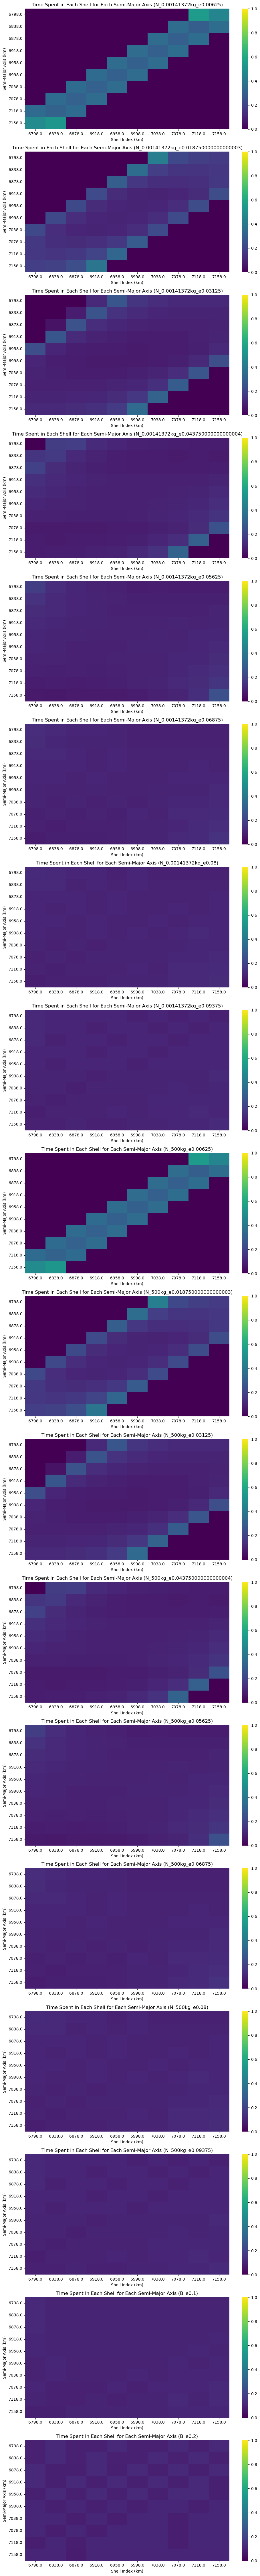

In [12]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming data is already loaded and contains species information
# Extract the time_per_shells data and corresponding semi-major axis bins
time_per_shells_data = []
species_names = []
semi_major_axis_bins = []

for species_group in data.species.values():
    for species in species_group:
        time_per_shells_data.append(species.time_per_shells)
        species_names.append(species.sym_name)
        semi_major_axis_bins.append(species.semi_major_axis_bins)

# Convert the list of lists into a 3D array
time_per_shells_array = np.array(time_per_shells_data)

# Plot each 2D array separately in a collage
num_plots = time_per_shells_array.shape[0]
fig, axes = plt.subplots(num_plots, 1, figsize=(10, 5 * num_plots))

for i in range(num_plots):
    ax = axes[i] if num_plots > 1 else axes
    sns.heatmap(time_per_shells_array[i], cmap='viridis', cbar=True, ax=ax,
                xticklabels=semi_major_axis_bins[i], yticklabels=semi_major_axis_bins[i][::-1],
                vmin=0, vmax=1)
    ax.set_xlabel('Shell Index (km)')
    ax.set_ylabel('Semi-Major Axis (km)')
    ax.set_title(f'Time Spent in Each Shell for Each Semi-Major Axis ({species_names[i]})')
    ax.invert_yaxis()  # Flip the y-axis

plt.tight_layout()
plt.show()

In [62]:
total_frag_count = 0

for species_pair in data.results:
    for elliptical_pair in species_pair.collision_processed:
        fragments = elliptical_pair.fragments 
        if fragments is not None:
            total_frag_count += sum(sum(sum(fragments)))
print(total_frag_count)

2229.1000000000085


In [71]:
with open('../scenario-properties-baseline.pkl', 'rb') as f:
    frag_spread = pickle.load(f)

In [76]:
total_frag_count = 0

for pair in frag_spread.collision_pairs:
    total_frag_count += sum(pair.gammas)
    print(pair.gammas)

print(total_frag_count)

Matrix([[-1, -1, 0, 0], [-1, -1, 0, 0], [-1, -1, 1.20000000000000, 0], [-1, -1, 0, 0], [-1, -1, 1.20000000000000, 0], [-1, -1, 1.20000000000000, 0], [-1, -1, 1.20000000000000, 0], [-1, -1, 1.20000000000000, 0], [-1, -1, 0, 0], [-1, -1, 0, 0]])
Matrix([[-1, -1, 1.20000000000000, 0], [-1, -1, 0, 0], [-1, -1, 1.20000000000000, 0], [-1, -1, 1.20000000000000, 0], [-1, -1, 0, 0], [-1, -1, 0, 0], [-1, -1, 1.20000000000000, 0], [-1, -1, 0, 0], [-1, -1, 0, 0], [-1, -1, 1.20000000000000, 0]])
Matrix([[-1, -1, 1661.40000000000, 0], [-1, -1, 1661.40000000000, 0], [-1, -1, 1661.40000000000, 0], [-1, -1, 1661.40000000000, 0], [-1, -1, 1661.40000000000, 0], [-1, -1, 1661.40000000000, 0], [-1, -1, 1661.40000000000, 0], [-1, -1, 1661.40000000000, 0], [-1, -1, 1661.40000000000, 0], [-1, -1, 1661.40000000000, 0]])
Matrix([[-1, -1, 0, 0], [-1, -1, 0, 0], [-1, -1, 0, 0], [-1, -1, 0, 0], [-1, -1, 0, 0], [-1, -1, 0, 0], [-1, -1, 0, 0], [-1, -1, 0, 0], [-1, -1, 0, 0], [-1, -1, 0, 0]])
Matrix([[-1, -1, 894.250

In [77]:
import numpy as np

# Assuming data.results is a list of SpeciesCollisionPair instances
num_shells = 10  # or however many shells you have

debris_species_names = [species.sym_name for species in data.species['debris']]
total_frag_count = 0
# Initialize gamma_matrix for each species_pair
for species_pair in data.results:
    gamma_matrix = np.zeros((num_shells, len(debris_species_names)))

    for elliptical_pair in species_pair.collision_processed:
        fragments = elliptical_pair.fragments 
        
        # Check if fragments is not None
        if fragments is not None:
            for shell_index in range(num_shells):
                for species_index in range(2):  # Assuming two species per pair
                    for eccentricity_index in range(8):  # Assuming 8 eccentricity bins
                        try:
                            frags = fragments[shell_index, species_index, eccentricity_index]
                            
                            # Only add if frags is valid
                            if frags is not None:
                                # Identify correct index in gamma_matrix based on species name
                                species_name = elliptical_pair.species1.sym_name if species_index == 0 else elliptical_pair.species2.sym_name
                                if species_name in debris_species_names:
                                    debris_index = debris_species_names.index(species_name)
                                    gamma_matrix[shell_index, debris_index] += frags
                                else:
                                    print('im here')
                        except Exception as e:
                            print(f"Error accessing fragments: {e}")
                            print(f"shell_index: {shell_index}, species_index: {species_index}, eccentricity_index: {eccentricity_index}")

    # Store the gamma_matrix for the current species_pair
    species_pair.gammas = gamma_matrix
    total_frag_count += sum(sum(gamma_matrix))

print(total_frag_count)

im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here


In [79]:
import re
debris_species_names = [species.sym_name for species in data.species['debris']]
pattern = re.compile(r'^N_[^_]+kg')
unique_names = set()

for name in debris_species_names:
    match = pattern.match(name)
    if match:
        unique_names.add(match.group())

# Count the unique occurrences
debris_species = len(unique_names)
print(unique_count
      )

2


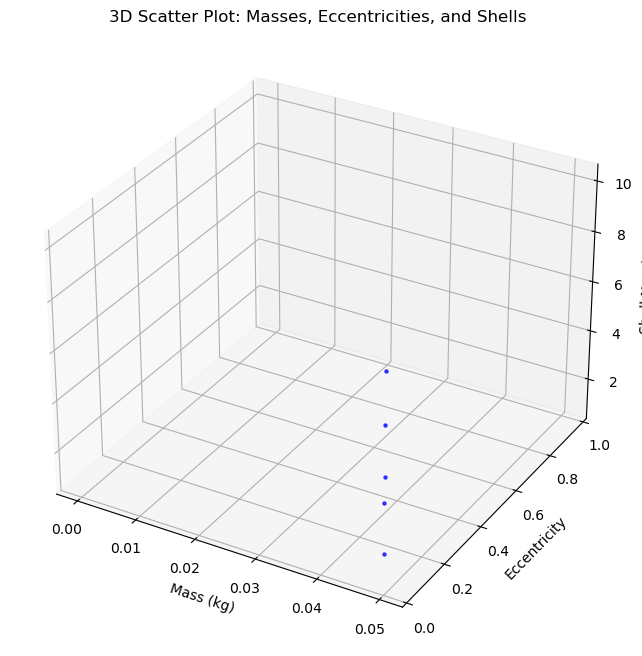

In [64]:
import numpy as np
import matplotlib.pyplot as plt


fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

fragments = data.results[5011].fragments[0]

# Loop through the n_shells and fragments
for i in range(10):
    for j in range(fragments.shape[2]):  # Loop through the fragments
        mass = fragments[i, 0, j]
        ecc = fragments[i, 1, j]
        
        # Plot each fragment: x = mass, y = eccentricity, z = n_shell
        ax.scatter(mass, ecc, i + 1, s=np.log(mass + 1) * 100, c='b' if mass < 1 else 'r', alpha=0.7)

# Set plot labels
ax.set_title('3D Scatter Plot: Masses, Eccentricities, and Shells')
ax.set_xlabel('Mass (kg)')
ax.set_ylabel('Eccentricity')
ax.set_zlabel('Shell Number')
ax.set_ylim([0, 1])

# Show plot
plt.show()